# ทดสอบกระบวนการสร้างแบบจำลอง Regression ด้วย ML จาก Github Microsoft ใช้ Pipeline
https://github.com/MicrosoftDocs/ml-basics/blob/master/02%20-%20Regression.ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Read and cleansing data

In [ ]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
df.drop(df[df['rain_x'] <= 0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['rain_x'] < 1.0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['cappi1km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
#df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
#df.reset_index(drop=True)
#df.dropna(inplace=True)

In [ ]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_x
6,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
28,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
72,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
107,37.450751,35.934908,34.647741,31.643592,2018-06-01-01:00,PIN004,0.2
138,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
...,...,...,...,...,...,...,...
68305,NaN,NaN,NaN,NaN,2018-09-21-18:00,CNDN,0.4
68328,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
68334,18.423027,18.423027,18.423027,NaN,2018-09-21-18:00,NGBA,0.8
68411,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


### คำนวณฝนประมาณค่าจากเรดาร์ค่าด้วย ZR Vectorized Operations:

In [ ]:
#  Vectorized Operations:
constants = {
    'MP': (200, 1.6), # ZR marshall/palmer
    'RF': (250, 1.2), # ZR Rosenfeld
    'SC': (300, 1.4) # ZR Summer Deep Convection
}

for prefix, (a, b) in constants.items():
    for suffix in ['c1', 'c2', 'c3', 'c4']:
        dBZ_column = f'dBZ_{suffix}'
        rr_column = f'rr_{prefix}_{suffix}'
        df[rr_column] = ((10**(df[dBZ_column]/10.))/a)**(1/b)

In [ ]:
df['rain_truth']=df['rain_x'] #เพิ่มคอลัมน์ target ด้านหลังสุด
df.drop(columns=['rain_x','full_date','code'], inplace=True) #ลบคอลัน์

In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True)

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4,rain_truth
0,22.267728,22.656334,23.252944,23.492632,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350,0.4
1,37.450751,35.934908,34.647741,31.643592,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594,0.2
2,28.847841,28.025389,26.520176,24.078056,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255,0.2
3,45.845036,45.410100,44.329489,42.504659,26.740589,25.118143,21.500539,16.534742,66.395140,61.078967,49.641029,34.976114,32.009071,29.799314,24.947083,18.478841,2.8
4,35.427362,33.911951,33.814425,34.668089,5.971266,4.801238,4.734323,5.353180,8.994911,6.725314,6.600631,7.775424,5.769704,4.496865,4.425311,5.092368,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,22.052814,24.789279,27.074918,27.700281,0.871279,1.291773,1.794893,1.963920,0.690957,1.168127,1.811173,2.042083,0.639483,1.002976,1.460664,1.618897,0.8
2602,37.137746,36.378048,35.045844,33.341833,7.637749,6.846747,5.652252,4.423040,12.489034,10.794950,8.359949,6.028410,7.644055,6.746207,5.418789,4.094371,2.6
2603,21.603189,23.323372,24.247740,25.084608,0.816687,1.046085,1.194923,1.347858,0.633844,0.881721,1.052838,1.236234,0.593899,0.788103,0.917506,1.052896,0.2
2604,31.854776,31.898127,31.546525,29.810020,3.570917,3.593265,3.415970,2.660618,4.531911,4.569766,4.271631,3.061153,3.206039,3.228980,3.047550,2.290418,2.4


## Feature selection

###  Correlation Analysis:

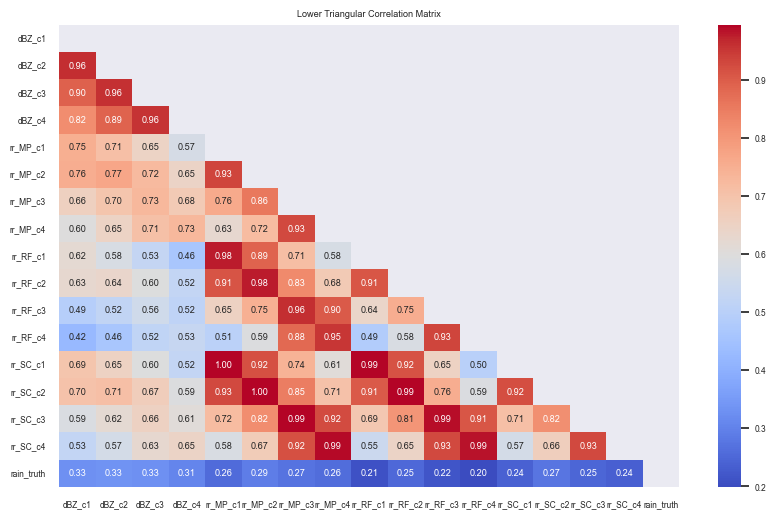

important_features_corr: ['rain_truth', 'dBZ_c2', 'dBZ_c1', 'dBZ_c3', 'dBZ_c4', 'rr_MP_c2', 'rr_SC_c2', 'rr_MP_c3', 'rr_MP_c4', 'rr_MP_c1', 'rr_RF_c2', 'rr_SC_c3', 'rr_SC_c1', 'rr_SC_c4', 'rr_RF_c3', 'rr_RF_c1']


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

# Create a mask for the lower triangular part
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the font scale for the heatmap
sns.set(font_scale=0.55)  # Adjust the font scale as needed

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Lower Triangular Correlation Matrix")
plt.show()

# Identify features highly correlated with the target
correlation_with_target = correlation_matrix['rain_truth'].abs().sort_values(ascending=False)
important_features_corr = correlation_with_target[correlation_with_target > 0.20].index.tolist()
print('important_features_corr:', important_features_corr)

## Preprocess data pipe line

In [8]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 1824 rows
Test Set: 782 rows


### Train the model : Ensemble model>GradientBoostingRegressor

In [9]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
#numeric_features = [0,1,2,3,4,5]
numeric_features = [0,1,2,3]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
#categorical_features = [4]
#categorical_transformer = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])#,
        #('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

# Get predictions
predictions = model.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', GradientBoostingRegressor())])


### ประเมินแบบจำลอง

MSE: 28.448784569345225
RMSE: 5.333740204523016
R2: -0.010808939600264855


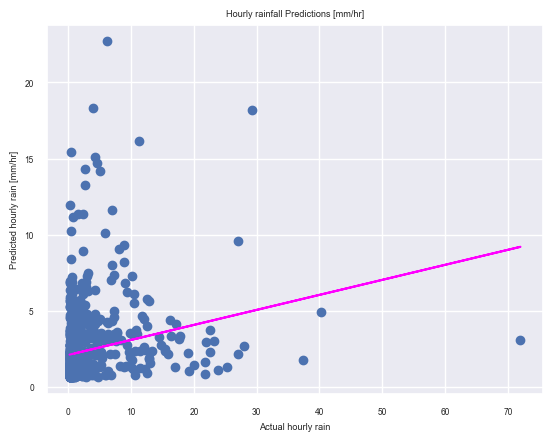

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## ฟังก์ชั่น density plot

In [11]:
def density_plot(y_test,predictions):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # data
    x=y_test.transpose().flatten()
    y=predictions.flatten()

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50,cmap='jet')

    plt.xlabel('Actual hourly rain')
    plt.ylabel('Predicted hourly rain [mm/hr]')
    plt.title('Hourly rainfall Predictions [mm/hr]')
    z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
    p = np.poly1d(z)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='magenta', linewidth=2)
    #plt.plot(y_test,p(y_test), color='magenta')
    plt.show()

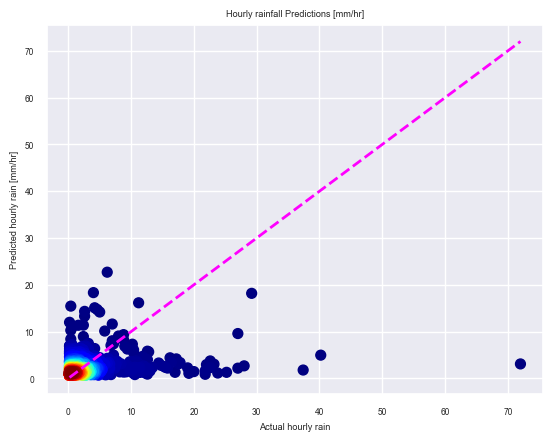

In [12]:
density_plot(y_test,predictions)

### try Train the model : Ensemble model > RandomForestRegressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', RandomForestRegressor())]) 



### ประเมินแบบจำลอง

MSE: 28.728054127877243
RMSE: 5.359855793571059
R2: -0.020731618920159844


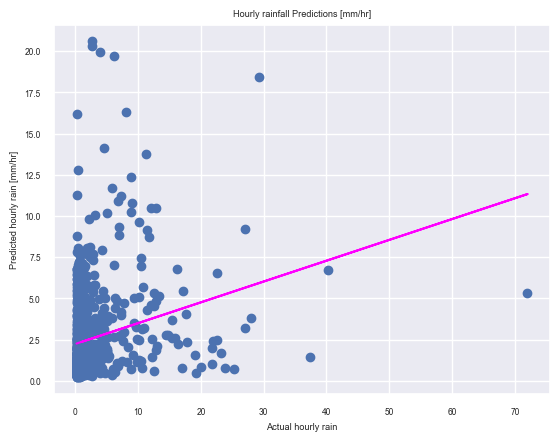

In [14]:
# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

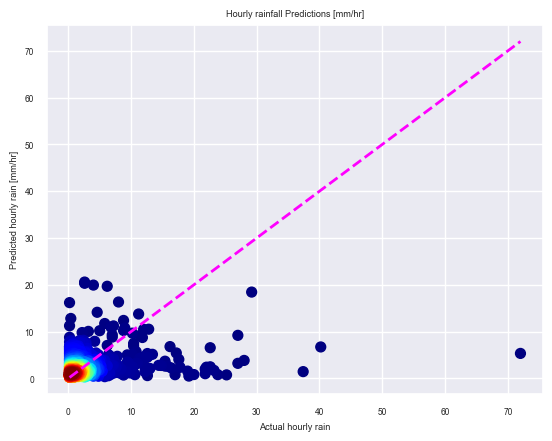

In [15]:
density_plot(y_test,predictions)

## Cross validation of pipeline with 3 แบบจำลอง แล้วตัดสินใจแบบจำลองที่ดีที่สุด

In [16]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define preprocessing for numeric columns (scale them)
#numeric_features = [0, 1, 2, 3, 4, 5]
numeric_features = [0, 1, 2, 3]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Create a list of regressors
regressors = [
    ('GradientBoosting', GradientBoostingRegressor()),
    ('RandomForest', RandomForestRegressor()),
    ('DecisionTree', DecisionTreeRegressor())
]

# Define the number of folds for cross-validation
num_folds = 5

# Define scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)))
r2_scorer = make_scorer(r2_score)

# Define weights for each metric
weights = {'mse': 0.4, 'mae': 0.2, 'rmse': 0.2, 'r2': 0.2}

# Initialize variables to store composite scores
composite_scores = {}

# Loop through each regressor and calculate composite scores
for regressor_name, regressor in regressors:
    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

    # Perform k-fold cross-validation for the pipeline
    mse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mse_scorer)
    mae_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mae_scorer)
    rmse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=rmse_scorer)
    r2_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=r2_scorer)

    # Calculate average cross-validation scores
    avg_mse = -mse_scores.mean()
    avg_mae = mae_scores.mean()
    avg_rmse = rmse_scores.mean()
    avg_r2 = r2_scores.mean()

    # Calculate composite score
    composite_score = (
        weights['mse'] * avg_mse +
        weights['mae'] * avg_mae +
        weights['rmse'] * avg_rmse +
        weights['r2'] * avg_r2
    )

    # Store composite score for each regressor
    composite_scores[regressor_name] = composite_score

# Print the composite scores for each model
for regressor_name, score in composite_scores.items():
    print(f"{regressor_name} Composite Score: {score:.4f}")

# Decide which model is the best based on the composite scores
best_model = max(composite_scores, key=composite_scores.get)
print(f"The best model is {best_model}.")

GradientBoosting Composite Score: 10.2490
RandomForest Composite Score: 9.9752
DecisionTree Composite Score: 16.8045
The best model is DecisionTree.


## Cross validation of pipeline with 5 แบบจำลอง แล้วตัดสินใจแบบจำลองที่ดีที่สุด

In [17]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define preprocessing for numeric columns (scale them)
#numeric_features = [0, 1, 2, 3, 4, 5]
numeric_features = [0, 1, 2, 3]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Create a list of regressors
regressors = [
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso()),
    ('GradientBoosting', GradientBoostingRegressor()),
    ('RandomForest', RandomForestRegressor()),
    ('DecisionTree', DecisionTreeRegressor())
]

# Define the number of folds for cross-validation
num_folds = 5

# Define scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)))
r2_scorer = make_scorer(r2_score)

# Define weights for each metric
weights = {'mse': 0.0, 'mae': 0.0, 'rmse': 0.5, 'r2': 0.5}
#weights = {'mse': 0.25, 'mae': 0.25, 'rmse': 0.25, 'r2': 0.25}
#weights = {'mse': 0.4, 'mae': 0.2, 'rmse': 0.2, 'r2': 0.2}
#weights = {'mse': 0.0, 'mae': 0.0, 'rmse': 1.0, 'r2': 0.0}

# Initialize variables to store composite scores
composite_scores = {}

# Loop through each regressor and calculate composite scores
for regressor_name, regressor in regressors:
    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

    # Perform k-fold cross-validation for the pipeline
    mse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mse_scorer)
    mae_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mae_scorer)
    rmse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=rmse_scorer)
    r2_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=r2_scorer)

    # Calculate average cross-validation scores
    avg_mse = -mse_scores.mean()
    avg_mae = mae_scores.mean()
    avg_rmse = rmse_scores.mean()
    avg_r2 = r2_scores.mean()

    # Calculate composite score
    composite_score = (
        weights['mse'] * avg_mse +
        weights['mae'] * avg_mae +
        weights['rmse'] * avg_rmse +
        weights['r2'] * avg_r2
    )

    # Store composite score for each regressor
    composite_scores[regressor_name] = composite_score

# Print the composite scores for each model
for regressor_name, score in composite_scores.items():
    print(f"{regressor_name} Composite Score: {score:.4f}")

# Decide which model is the best based on the composite scores
best_model = max(composite_scores, key=composite_scores.get)
print(f"The best model is {best_model}.")


LinearRegression Composite Score: 2.0226
Lasso Composite Score: 2.0596
GradientBoosting Composite Score: 2.0630
RandomForest Composite Score: 2.0668
DecisionTree Composite Score: 1.9861
The best model is RandomForest.


### plot graph results of CV models

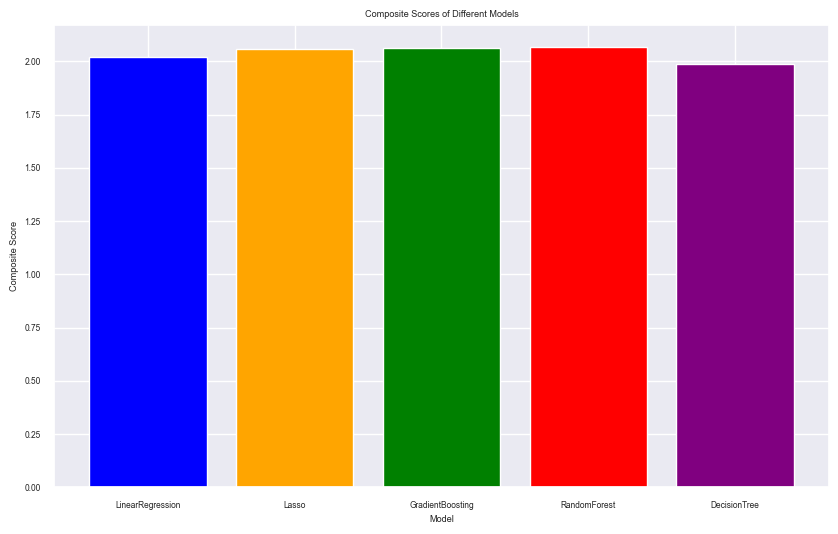

In [18]:
import matplotlib.pyplot as plt

# Extract model names and composite scores
model_names = list(composite_scores.keys())
composite_scores_values = list(composite_scores.values())

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, composite_scores_values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title("Composite Scores of Different Models")
plt.xlabel("Model")
plt.ylabel("Composite Score")
plt.show()

### validation plot for the best model: LinearRegression

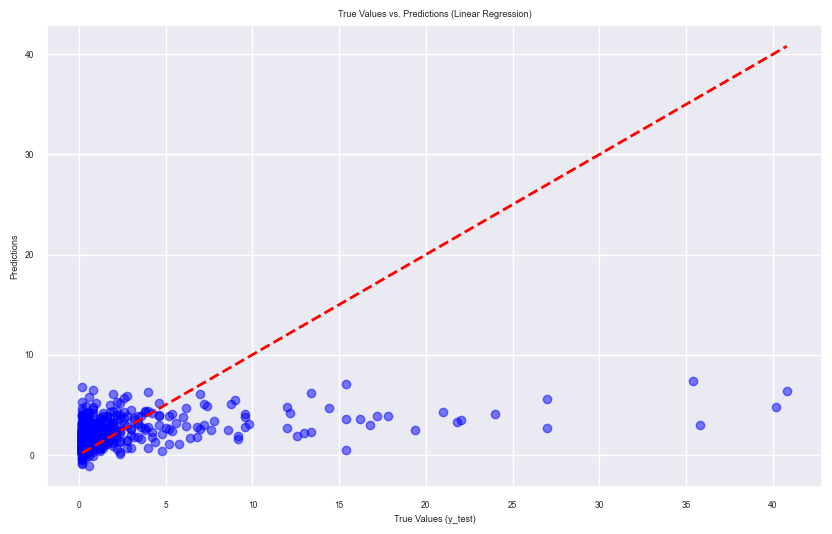

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = linear_reg_model.predict(X_test)

# Plot the scatter plot of true values vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.title("True Values vs. Predictions (Linear Regression)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions")

# Plot the fitted line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

plt.show()


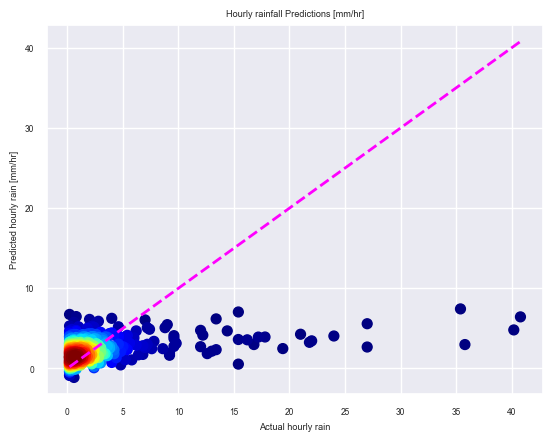

In [20]:
density_plot(y_test,predictions)

###  validation plot for the RandomForestRegressor

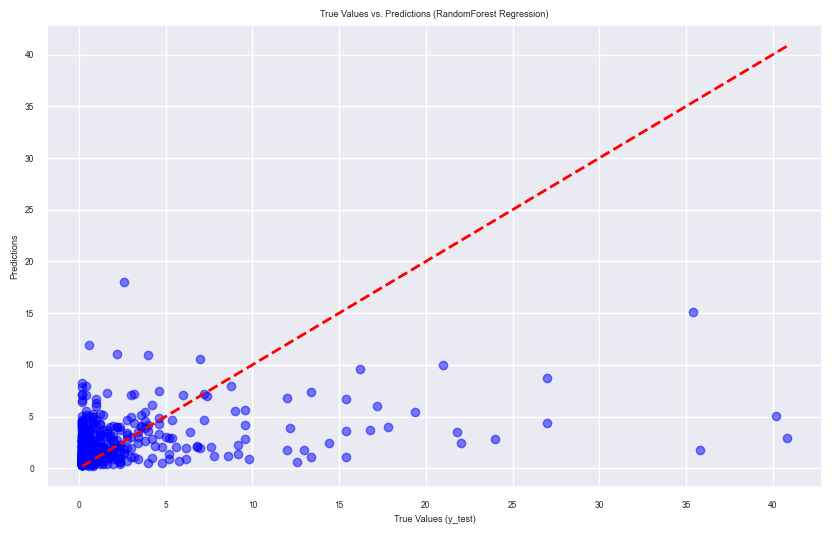

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
RandomForest_reg_model = RandomForestRegressor()
RandomForest_reg_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = RandomForest_reg_model.predict(X_test)

# Plot the scatter plot of true values vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.title("True Values vs. Predictions (RandomForest Regression)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions")

# Plot the fitted line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

plt.show()


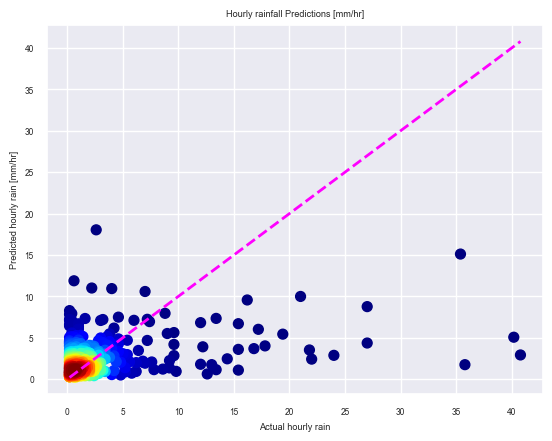

In [22]:
density_plot(y_test,predictions)

###  validation plot for the GradientBoostingRegressor

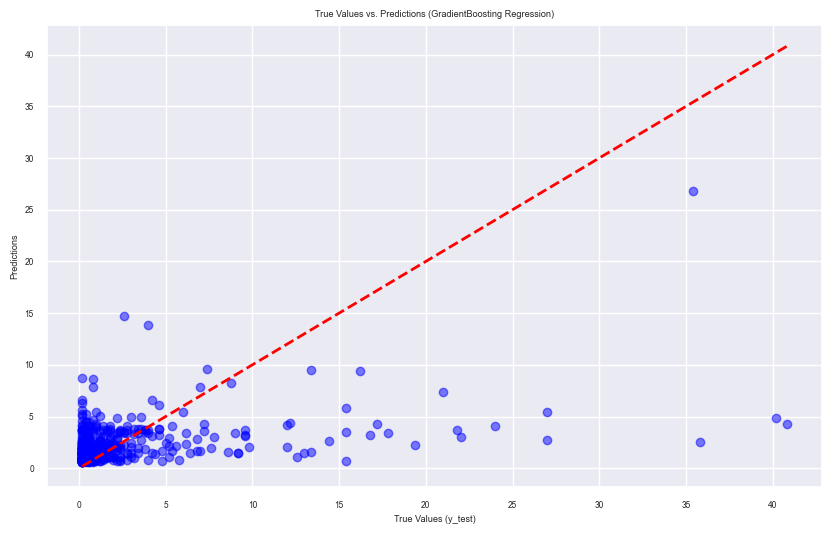

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
GradientBoosting_reg_model = GradientBoostingRegressor()
GradientBoosting_reg_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = GradientBoosting_reg_model.predict(X_test)

# Plot the scatter plot of true values vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.title("True Values vs. Predictions (GradientBoosting Regression)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions")

# Plot the fitted line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

plt.show()

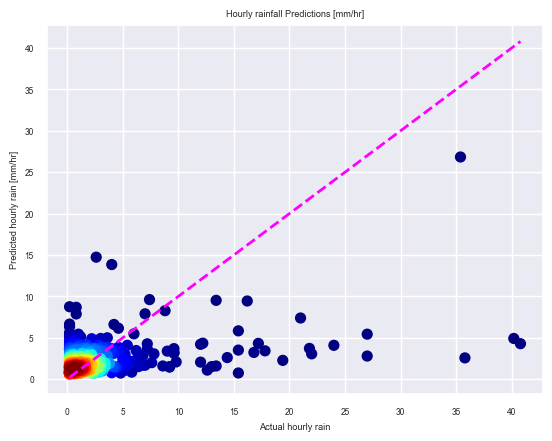

In [24]:
density_plot(y_test,predictions)

## Optimization: Hyperparameter tuning


### ทดสอบกับ GradientBoostingRegressor

#### score ใช้ r2

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 

MSE: 20.403669388586653
RMSE: 4.517042106133908
R2: 0.15859193117701575
Correlation coefficient (r): 0.40723471393049254
P-value: 2.8484885311637234e-22


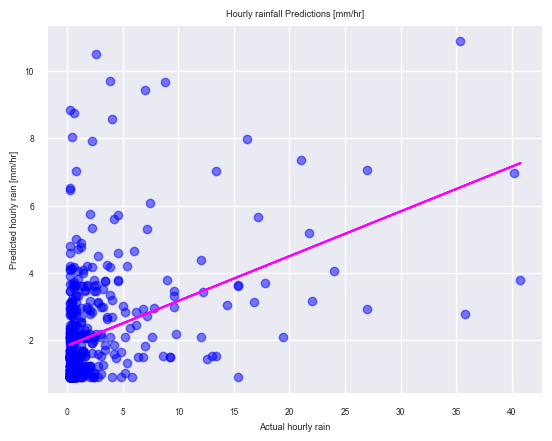

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import linregress

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV with 'r2' as the scoring parameter
score = 'r2'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density

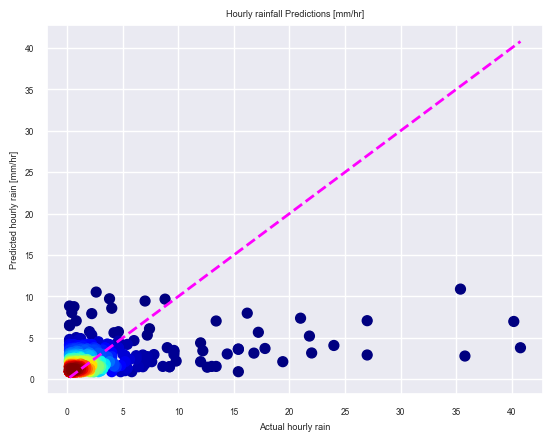

In [26]:
density_plot(y_test,predictions)

#### score ใช้ rmse

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 

MSE: 19.942753851237914
RMSE: 4.465731054512566
R2: 0.17759920113347016
Correlation coefficient (r): 0.43937218480328366
P-value: 4.76321602273469e-26


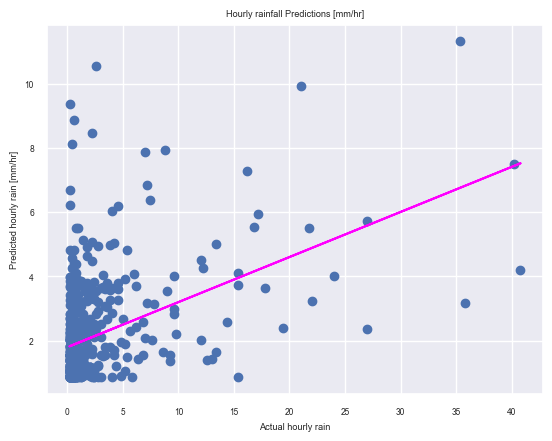

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density

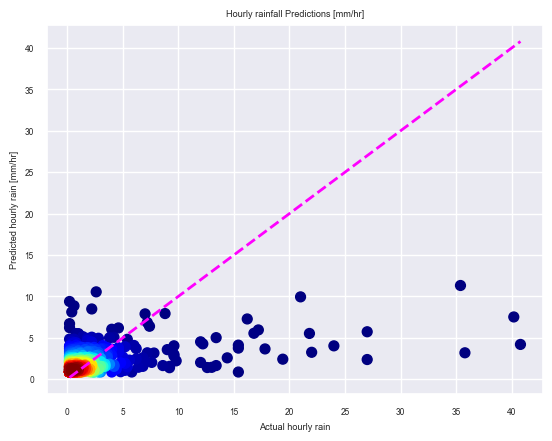

In [28]:
density_plot(y_test,predictions)

### ทดสอบกับ RandomForest

Best parameter combination: {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 108} 

RandomForestRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=108) 

MSE: 20.51291077022462
RMSE: 4.529118100715041
R2: 0.15408702677923247
Correlation coefficient (r): 0.41829597317069084
P-value: 1.5861047555293072e-23


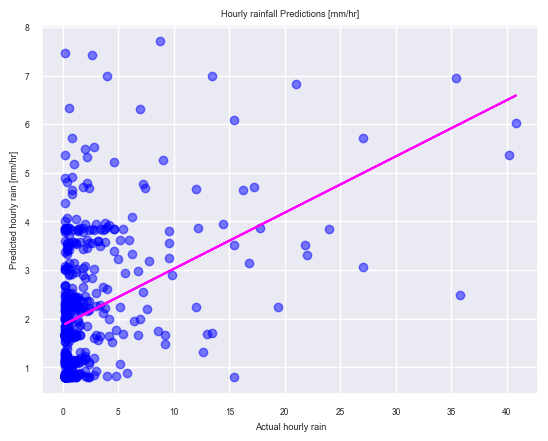

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# Use a Random Forest algorithm
alg = RandomForestRegressor()

# Define the hyperparameter search space
params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density plot

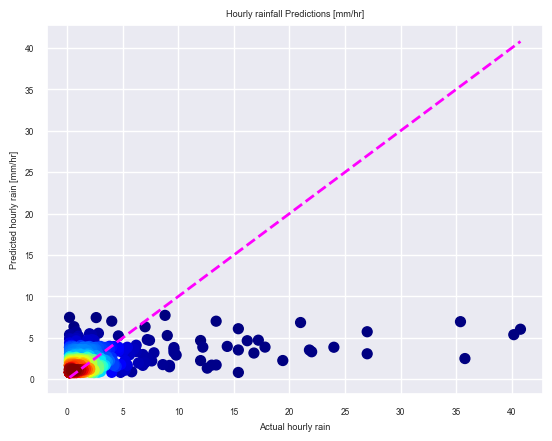

In [30]:
density_plot(y_test,predictions)

### ทดสอบกับ Decision Tree

Best parameter combination: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 6, 'splitter': 'random'} 

DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=6,
                      splitter='random') 

MSE: 21.06526454775339
RMSE: 4.589691116813134
R2: 0.1313090197253869
Correlation coefficient (r): 0.3764122051623287
P-value: 5.142275530214736e-19


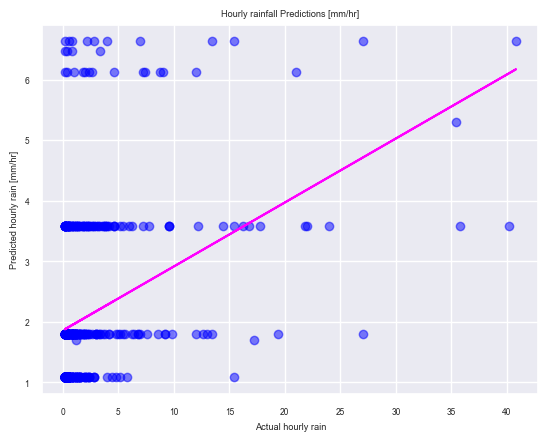

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

# Use a Decision Tree algorithm
alg = DecisionTreeRegressor()

# Define the hyperparameter search space
params = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'splitter': ['best', 'random']
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density plot

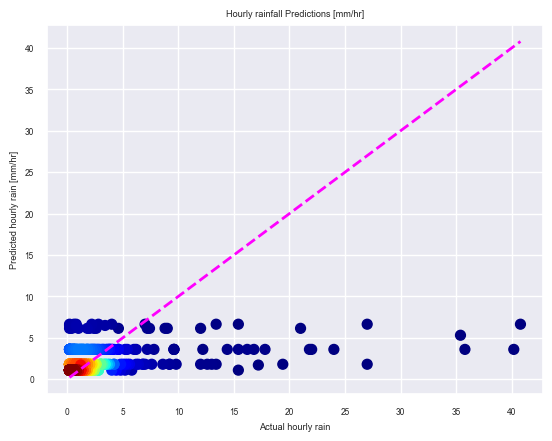

In [32]:
density_plot(y_test,predictions)

### ทดสอบกับ Linear Regression

Best parameter combination: {'normalize': True, 'n_jobs': -1, 'fit_intercept': True, 'copy_X': True} 

LinearRegression(n_jobs=-1, normalize=True) 

MSE: 20.60800617822315
RMSE: 4.539604187395984
R2: 0.15016547511741563
Correlation coefficient (r): 0.40685359521355086
P-value: 3.1405335336311866e-22


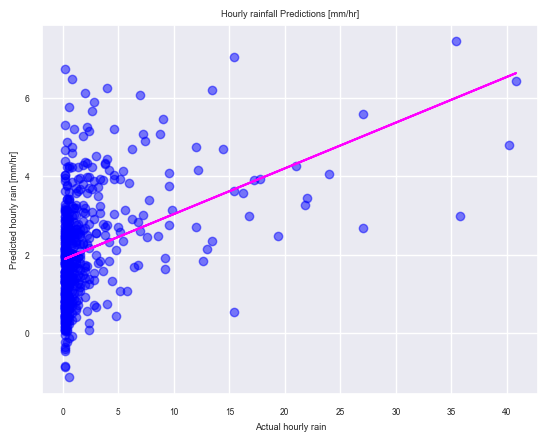

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Use a Linear Regression algorithm
alg = LinearRegression()

# Define the hyperparameter search space
params = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, 1]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density

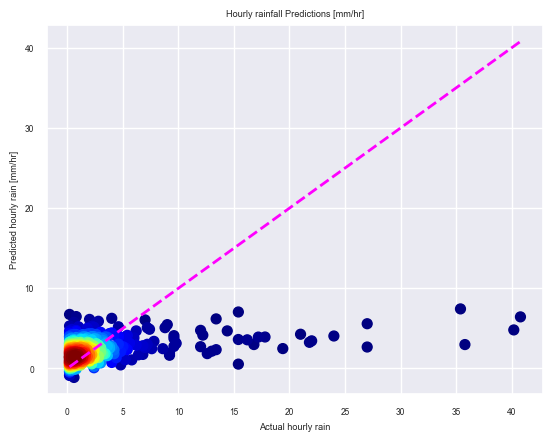

In [34]:
density_plot(y_test,predictions)

## สังเกต
ฝนรายชั่วโมง จาก dBZ ให้ค่าไม่ดี ควรทดสอบ
* ใช้ค่า zr แปลงเป็นฝน แล้วทำการ aggegrate เวลา เป็นรายวัน แล้วทำการหาแบบจำลองที่จะทำนายฝนรายวันจากเรดาร์ตรวจอากาศให้ได้ แต่ทดสอบหาความสัมพันธ์ระหว่างฝนเรดาร์ กับ ฝนภาคพื้นดิน 1, 3, 6, 12, 24 ชั่วโมงดูก่อน ว่าอันไหนดีสุด แล้วค่อยเลือกช่วงเวลาที่สั้นที่สุด มาทำการสร้างแบบจำลอง เล่นกับมุมยกเดียวก่อน cappi 1 km แล้วค่อยๆ เพิ่ม